# Avengers Faces Classification

### Group members:
*Chiyu Ma*,  *Sijie Chen*,  *Tengjie(TJ) Tang*,  *Ying Xin*,  *Xiaoyue(Emrys) Yan*,  *Tianhao Li*

## Introduction



For this project, we intended to build some image classification models for facial recognition based on the "Avengers Faces Dataset" on Kaggle. It is essentially a “which Avenger is your look-alike” game. We attempted to create a facial recognition model to specifically identify and tell apart five Avengers/actors: Scarlett Johansson, Robert Downey Jr., Chris Evans, Chris Hemsworth, and Mark Ruffalo. Our goal is to match a human face on a digital image against a database of Avengers' faces by pinpointing and measuring facial features from a given image. So we can identify the Avengers and also find out the Avenger-look-alike for each MSS student.

We started with training the algorithm to recognize the five Avengers. Originally there were 274 samples in the training set and 60 same samples in both validation set and test set. The original test and validation sets contain same data and are included in the training set, so here we removed the validation set and removed those duplicate data from the training set. Now there are 214 samples in training set, 60 samples in testing set. Utilized machine learning methods were: convolutional neural network (CNN), Feedforward Neural Network(FNN), Random Forest, and Adaboost. We obtained accuracy rate for each model, and realized CNN and FNN are the best performing ones after comparing each model's performance and preferences. Then we visually compared traning errors for CNN and FNN in their 100 training epoches, and we performed data augmentation by blurring images to increase the robustness of our model. It is then obvious that CNN achieved the highest accuracy, exceeding those of FNN, Adaboost and Random Forest before augmentation. We obtained an accuracy of 75%.

Then we put our algorithm into practice by feeding MSS student profile headshots that we scrapped from MSS websites to it and looking for each student's look-alike Avenger. We processed student headshots the same way we did with the five Avengers photos, ran the algorithm, and labeled students with their Avenger-look-alike. The detailed write-up on this part is in the "Classmates photos" section.

## Methods / Implementation

In [1]:
import os 
import shutil 
import cv2
import numpy as np 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import warnings
import matplotlib.pyplot as plt
import torch.optim as optim 
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

/Users/litianhao/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preprocessing 

In this section, we transformed the the dataset stored in our repository into the corresponding `.npy` file. For each image, we built its path based on its label and which set it belonged to. Then for each label, we read in and resize these images into same size and stored them in the corresponding `.npy` file.

In [2]:
REBUILD_DATA = True

class Preprocess():
    avengers = ['chris_evans', 'chris_hemsworth','mark_ruffalo','robert_downey_jr','scarlett_johansson']
    Labels = {value: indx for indx, value in enumerate(avengers)}
    data = []
    # make the data based on set label
    def make_data(self, mode, size = 50):
        # assign mod and file name based on set mode
        if mode == "training":
            mod, name = 'train/', "train_data.npy"
        elif mode == "testing":
            mod, name  = 'test/', "test_data.npy"
        else:
            raise RuntimeError("mode should be chosen within training or testing")
        
        # label and load the data to corresponding set
        for lab in self.Labels:
            label = 'images/'+ mod + lab
            for f in tqdm(os.listdir(label)):
                # build path
                path = os.path.join(label, f)
                # read in image
                image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                # resize image to 50X50
                image = cv2.resize(image, (size, size)) # all 50x50 size images
                # add the processed data to output file
                self.data.append([np.array(image), np.eye(5)[self.Labels[lab]]])
        np.save(name, self.data)
        self.data = []
            

In [3]:
# build the training set and testing set
if REBUILD_DATA:
    Data_preprocess = Preprocess()
    print("Data Preprocessing:")
    
    # process training data
    print('Processing training data:')
    Data_preprocess.make_data('training')
    train = np.load("train_data.npy", allow_pickle = True)
    print()
    
    # process testing data
    print('Processing testing data:')
    Data_preprocess.make_data("testing")
    test = np.load('test_data.npy',allow_pickle = True)
    print("Done")
    
    # reset data process indicator
    REBUILD_DATA = False 

Data Preprocessing:
Processing training data:


100%|██████████████████████████████████████████| 42/42 [00:00<00:00, 190.36it/s]
/Users/litianhao/opt/anaconda3/envs/cv/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



Processing testing data:


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 112.66it/s]

Done


In [4]:
# check sets sizes
print('The size of training set is: ',len(train))
print('The size of testing set is: ',len(test))

The size of training set is:  214
The size of testing set is:  60


Here are 2 samples of data points.

array([0., 1., 0., 0., 0.])

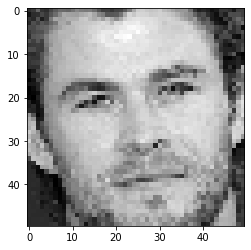

In [5]:
plt.imshow(train[42][0], 
          cmap= "gray")
plt.show
train[42][1]

array([1., 0., 0., 0., 0.])

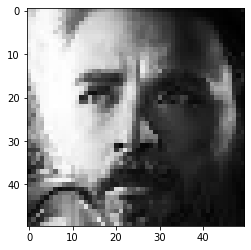

In [6]:
plt.imshow(test[3][0], 
          cmap= "gray")
plt.show
test[3][1]

## Constructing Different Model without Data Augmentation

One thing to mention here is that we did not add data augmentation at the beginning, because we found that the data augmentation operations seem to have significant influence on the data. Given the influence of data augmentation, we would need more complex model to capture the features and more data to train the model. However, here we only have very limited amount of data, so even if we add more layers to the neural network model, the data augmentation would lead to poor result.

### Building CNN 

Image classification involves the extraction of features from the image to observe some patterns in the dataset. The filter used in CNN can help us extract these features, making CNN a good choice for image classification. We constructed CNN with three convolution layers with 5*5 filter windows, three max pooling layers, and three fully connected linear layers. We used relu activation function on the first two FC layers, and softmax activation function for the output given it is the most suitable activation function for mulitclass classifciation.

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 5x5 kernel size or windows
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,5)
               
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2)) 
        
        # to calculate the dimension from convolution 
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x 
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim = 1)

In [40]:
net = Net()

In [46]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
# use MSE loss
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in train]).view(-1,50, 50)# 50 as default 
# scaling the boundary
X = X/255.0
y = torch.Tensor([i[1] for i in train])

In [184]:
epochs = 100
train_loss_cnn = []
for epoch in tqdm(range(epochs)):
        net.zero_grad()
        outputs = net(X.view(-1,1,50, 50))
        loss = loss_function(outputs, y)
        train_loss_cnn.append(loss)
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


In [185]:
test_X = torch.Tensor([i[0] for i in test]).view(-1,50, 50)# 50 as default 
# scaling the boundary
test_X = test_X/255.0
test_y = torch.Tensor([i[1] for i in test])

In [186]:
correct = 0
total = 0 
outp = []
with torch.no_grad():
    for i in range(len(test_X)):
        real = torch.argmax(test_y[i])
        out = net(test_X[i].view(-1,1,50, 50))[0]
        predicted = torch.argmax(out)
        outp.append(predicted)
        if predicted == real:
            correct +=1 
        total +=1 
print("Accuracy:", round(correct/total, 3)*100,'%')

Accuracy: 75.0 %


### Building Feedforward Neural Network (FNN)

Besides CNN, we also implemented Feedforward Neural Network (FNN), which was the first and simplest type of artificial neural network devised. Although the model is much simpler than CNN with only three linear layers, its performance is not much worse than CNN. We obatined an accuracy score of $70 \%$.

In [200]:
class fnn_model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nl_step = nn.ReLU(), seed=1234):
        super().__init__()
        self.l1 = torch.nn.Linear(input_dim, hidden_dim)
        self.nl = nl_step # ReLU
        self.l2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.nl = nl_step
        self.l3 = torch.nn.Linear(hidden_dim, output_dim)
    def forward(self, X):
        out = self.l1(X)
        out = self.nl(out)
        out = self.l2(out)
        out = self.nl(out)
        out = self.l3(out)
        return out

In [201]:
m = fnn_model(50*50,50,5)

In [202]:
optimizer = optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in train]).view(-1,50*50)# 50 as default 
# scaling the boundary
X = X/255.0
y = torch.Tensor([i[1] for i in train])
epochs = 100
for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = m(X.view(-1,50*50))
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
print(loss)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 303.03it/s]

tensor(0.0359, grad_fn=<MseLossBackward0>)


In [205]:
correct = 0
total = 0 
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real = torch.argmax(test_y[i])
        out = m(test_X[i].view(-1,50*50))[0]
        predicted = torch.argmax(out)
        if predicted == real:
            correct +=1 
        total +=1 
print("Accuracy:", round(correct/total, 3)*100,'%')

100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 3334.94it/s]

Accuracy: 70.0 %


### Implement Random Forest

Besides implementing neural networks for image classifications, we attempted to use ensemble methods such as random forest and adaboost. We obtained accuracy around $70\%$ before tuning, and $73\%$ after hyper parameter tuning done by cross validation with startified k folds, and obatined parameters: `max_depth = 29`, `max_features= sqrt`,`min_samples_leaf=2`, `n_estimator=200`.


In [165]:
x_train,y_train = [train[i][0].flatten() for i in range(len(train))],[train[i][1] for i in range(len(train))]
y_train = np.argmax(y_train,axis=1)+1

In [166]:
x_test = [test[i][0].flatten() for i in range(len(test))]
y_test= np.argmax([test[i][1].flatten() for i in range(len(test))],axis=1)+1

In [167]:
clf = RandomForestClassifier()

In [168]:
# without tuning
clf.fit(x_train,y_train)
y_pred_test = clf.predict(x_test)
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           1       0.89      0.67      0.76        12
           2       0.80      0.67      0.73        12
           3       0.56      0.83      0.67        12
           4       0.78      0.58      0.67        12
           5       0.64      0.75      0.69        12

    accuracy                           0.70        60
   macro avg       0.73      0.70      0.70        60
weighted avg       0.73      0.70      0.70        60



In [169]:
# tuning RF
parameters = {
    'n_estimators':[180,190,200],
    'max_depth': [25,27,29,31],
    'min_samples_leaf': [2,3]
}

In [170]:
%%time 
rf_cv = GridSearchCV(
    RandomForestClassifier(bootstrap=True,max_features='sqrt'),
    parameters,
    n_jobs=-1,
    cv = StratifiedKFold(5, shuffle=True, random_state=663),
    scoring = "accuracy").fit(x_train,y_train)

Wall time: 24.5 s


In [171]:
rf_cv.best_estimator_

RandomForestClassifier(max_depth=29, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=200)

In [172]:
rf_cv.best_score_

0.6497231450719824

In [173]:
# check on test set
rf_best = rf_cv.best_estimator_
rf_best.fit(x_train, y_train)
y_pred= rf_best.predict(x_test) 
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred))

              precision    recall  f1-score   support

           1       0.80      0.67      0.73        12
           2       0.73      0.67      0.70        12
           3       0.67      0.83      0.74        12
           4       0.73      0.67      0.70        12
           5       0.77      0.83      0.80        12

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



### Implement AdaBoost

We also tried Adaptive Boosting with Decision Tree as the base learner. After tuning, the accuracy score is around 50%, which is worse than the other models we tried before.

In [162]:
# Adaboost tuning
ada_gs = GridSearchCV(
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier()), # base learner
    param_grid = {"base_estimator__criterion": ["gini", "entropy"],
              "n_estimators": [10,30,50,70]
    },
    cv = StratifiedKFold(5, shuffle=True, random_state=1234),
    n_jobs = -1,
    scoring = "accuracy"
).fit(
    x_train, y_train
)

print(ada_gs.best_estimator_)
print(ada_gs.best_score_)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
0.48117386489479513


In [163]:
# check on test set
ada_best = ada_gs.best_estimator_
ada_best.fit(x_train,y_train)
y_pred_test = ada_best.predict(x_test)
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))

              precision    recall  f1-score   support

           1       0.50      0.58      0.54        12
           2       0.46      0.50      0.48        12
           3       0.46      0.50      0.48        12
           4       0.33      0.33      0.33        12
           5       0.62      0.42      0.50        12

    accuracy                           0.47        60
   macro avg       0.48      0.47      0.47        60
weighted avg       0.48      0.47      0.47        60



## Model Diagnostic

Here we visualized the training loss during 100 training epoches for CNN and FNN. For the two curves, we may observe that the training loss for CNN decreases much slower than FNN. After checking the prediction accuracy on test set, we may conclude that FNN has a higher possibility of overfitting. Also, the curve for FNN has a sudden explosion at the first few epochs,  and then decrease normally. 

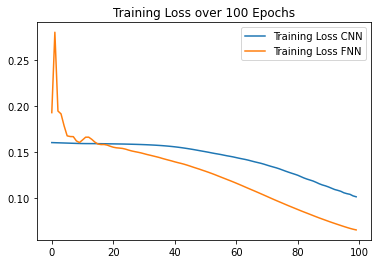

In [30]:
# visualization
train_loss_cnn = [i.detach() for i in train_loss_cnn]
train_loss_fnn = [i.detach() for i in train_loss_fnn]
plt.plot(train_loss_cnn,label='Training Loss CNN')
plt.plot(train_loss_fnn,label='Training Loss FNN')
plt.legend()
plt.title('Training Loss over 100 Epochs')
plt.show()

### Data Augmentation

To increase the robustness of our model, we performed data augmentation by rotating images by 45 degree, vertically flipping images and blurring images. However, we found that after we added rotating and flipping operations, the performance was relatively worse. Besides, even if we adjusted the structure of neural network, we did not see much improvement. We found out that if we only kept blurring in our augmentation, CNN with a slightly modified structure could produce a satisfactory result. We thought the decrease in accuracy after full augmentation is due to the limited size of input data and the singularity of the image types in our testing set. If our testing set contained actor's photos from more diverse angles, we might reach higher accuracy after the full augmentation. 

In [5]:
# data augmentation 
final_train = []
for i in tqdm(range(len(train))):
    final_train.append(train[i])
    #append flipped data
    #append_content = (rotate(train[i][0],angle=45,mode='wrap'),train[i][1])
    #final_train.append(append_content)
    #append vertically flipped data
    #append_content2 = (np.flipud(train[i][0]),train[i][1])
    #final_train.append(append_content2)
    #append blurred
    blurred = (gaussian(train[i][0],sigma=1,multichannel=True),train[i][1])
    final_train.append(blurred)

  0%|                                                   | 0/214 [00:00<?, ?it/s]/var/folders/d4/w16xnlgd49z0qdfvwmcpffwm0000gn/T/ipykernel_66080/2409646523.py:12: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = (gaussian(train[i][0],sigma=1,multichannel=True),train[i][1])
100%|███████████████████████████████████████| 214/214 [00:00<00:00, 5878.15it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

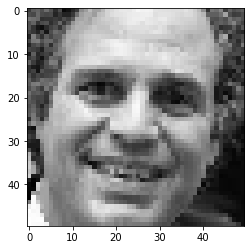

In [32]:
np.random.shuffle(final_train)
#check blurred
plt.imshow(final_train[1][0],
           cmap= 'gray')
plt.show

### Reconstruct CNN with augmented data
The structure of CNN with augmented data(blurring only) is slightly different from previous CNN in order to obtain a better performance. We changed the dimension of the second fully connected layer to `(512,1024)`, and the third fully connected layer to `(1024,5)`.

In [187]:
class Aug_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 5x5 kernel size or windows
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024,5)
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))        
        # to calculate the dimension from convolution 
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x 
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim = 1)

In [188]:
net = Aug_Net()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in final_train]).view(-1,50, 50)# 50 as default 
# scaling the boundary
X = X/255.0
y = torch.Tensor([i[1] for i in final_train])

In [192]:
epochs = 200
train_loss = []
for epoch in tqdm(range(epochs)):
        net.zero_grad()
        outputs = net(X.view(-1,1,50, 50))
        loss = loss_function(outputs, y)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:44<00:00,  1.12s/it]


In [190]:
test_X = torch.Tensor([i[0] for i in test]).view(-1,50, 50)# 50 as default 
# scaling the boundary
test_X = test_X/255.0
test_y = torch.Tensor([i[1] for i in test])

In [191]:
correct = 0
total = 0 
outp = []
with torch.no_grad():
    for i in range(len(test_X)):
        real = torch.argmax(test_y[i])
        out = net(test_X[i].view(-1,1,50, 50))[0]
        predicted = torch.argmax(out)
        outp.append(predicted)
        if predicted == real:
            correct +=1 
        total +=1 
#print(correct)
print("Accuracy:", round(correct/total, 3)*100,'%')

Accuracy: 71.7 %


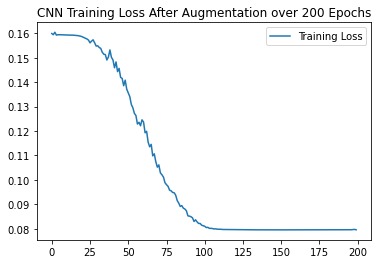

In [ ]:
train_loss = [i.detach() for i in train_loss]
plt.plot(train_loss,label='Training Loss')
plt.legend()
# indication of converge
plt.title('CNN Training Loss After Augmentation over 200 Epochs')
plt.show()

## Classmates Headshots Classification

In this section, we used the CNN model we fit in last section to make predictions on a new dataset. We are interested in which avenger will MSS students look alike.  

We first scrapped images from the MSS students website https://stat.duke.edu/people/students/ms-students. And then we processed the data the same way we did previously for our training and test data sets. Finally, we fit the CNN model and made predictions. Each MSS student was given a label of Avenger that was predicted by the CNN model. In our Avengers data set, only one of the Avengers is female, labelled as "scarlett_johansson," and the other four are all male characters. We evaluated the accuracy of classifications on gender recognition. We observed that almost all of the female students are labelled as "scarlett_johansson," the only female character in our Avenger data set, meanning that our gender accuracy is pretty good with women's headshots. On the other hand, a very small number of male students were labelled as "scarlett_johansson",so the algorithm could be further refined for processing men's headshots. However, given the limitations in the size of our training set, we could conclude that our model is doing the correct job. Unfortunately, it may not be very exciting for female students to see which avengers they look like the most because there is only one female character, and there might be some weird feelings when any female students are labeled as a male Avenger. So, we believe that if we can get more characters for the training data set, meaning a larger dataset, our model will produce more accurate predictions and more interesting results.

### Web Image Scraping

We used `BeautifulSoup` and `reqeust` to perform web image scraping. By using find_all, we were able to extract all the url links for image on MSS student page with class "image_style_people_ohtot_thmbnail". After extracting the urls, we completed the url by appending "stat.duke.edu" in the front. Finally, we used request.urlretrieve to download image files into the folder named classmates. 
We commented out the following two chunks becuase we only needed to download data once.

In [7]:
# # web scraping code inspired by : https://python.plainenglish.io/how-to-scrape-images-using-beautifulsoup4-in-python-e7a4ddb904b8
# DownloadOnce=False
# URL = "https://stat.duke.edu/people/students/ms-students"
# page = requests.get(URL)
# from bs4 import BeautifulSoup
# soup = BeautifulSoup(page.content, 'html.parser')
# image_tags = soup.find_all('img', class_='image-style-people-photo-thumbnail')
# links = []
# for image_tag in image_tags:
#     links.append(image_tag['src'])
# #complete url
# links_complete = ['http://stat.duke.edu'+i for i in links]

In [8]:
# import urllib.request
# if DownloadOnce == True:
#     for i in range(len(links_complete)):
#         urllib.request.urlretrieve(links_complete[i],os.getcwd()+'/images/classmates/classmate'+str(i)+'.jpg')
#     DownloadOnce = False

In [134]:
# read data and data processing
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images(path,size=50):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (size,size))
            images.append([np.array(img)])
    return images

In [125]:
classmate = load_images("images/classmates")
print(len(classmate)) # number of images in the classmate dataset

77


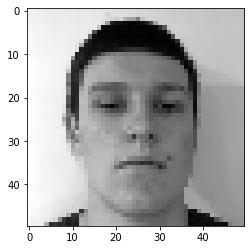

In [179]:
# an example of the classmate dataset
plt.imshow(classmate[3][0],cmap= "gray")
plt.show()

In [128]:
X_class = torch.Tensor([i for i in [classmate]]).view(-1,50, 50)# 50 as default 
X_class = X_class/255.0 # scaling 

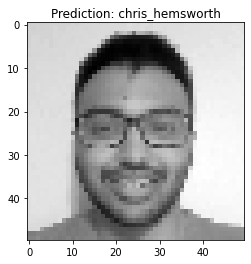

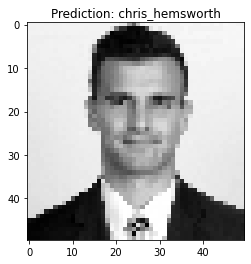

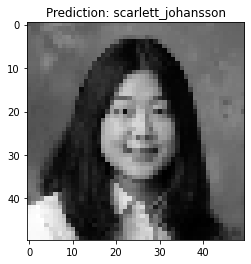

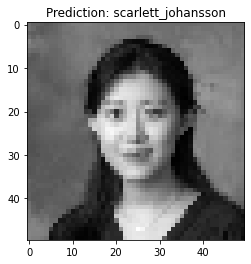

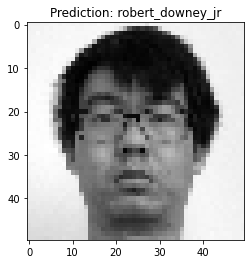

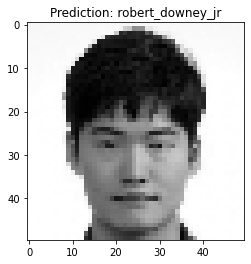

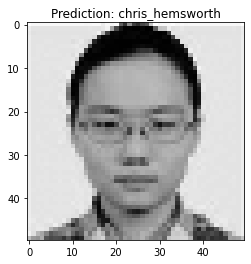

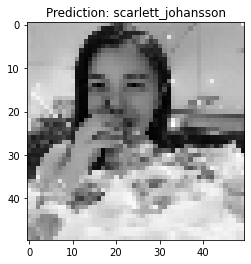

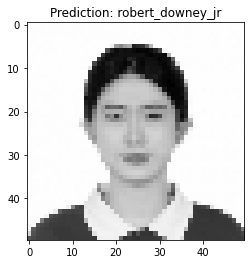

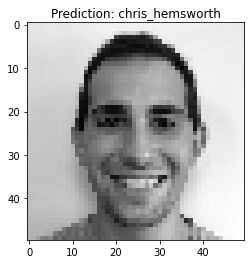

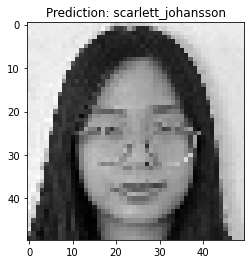

In [178]:
avengers = ['chris_evans', 'chris_hemsworth','mark_ruffalo','robert_downey_jr','scarlett_johansson']
with torch.no_grad():
    # to save space, only plot some of the results
    for index in range(0,len(classmate),7):
        outputs = net(X_class[index].view(-1,50,50)) # fit model
        predicted = np.argmax(outputs) # make prediction
        plt.imshow(X_class[index], cmap='gray')
        plt.title(f'Prediction: {avengers[predicted]}')
        plt.show()

## Discussion & Conclusions

Given the small size of our dataset, neural networks may not produce very high accuracy on test set due to overfitting. Nevertheless, we still adopted some good practice in the context of image classification and neural network. For example, we decided to solve this problem by using CNN, whose structure and features fit this problem very well. Besides, given the relatively small amount of data and a model that is not that complex, we considered adding data augmentation such as blurring the images (we found that other operations such as ratating the image have a too significant influence), which helps increase the robustness of the model.

As for future improvements, a major consideration is increasing the data input. Only by doing this can we fully take advantage of CNN and data augmentation.

## Reference

M Yasser H.(2022).Avengers Faces Dataset.Retrieved April 23.2022 from https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset